# Sparkify

## PySpark Machine Learning Project

Sparkify is a fictional music-streaming company, and in this notebook, I'm going to analyze Sparkify's streaming data to predict customers that are likely to churn.

Udacity provided two separate datasets, a mini-version (128MB), which was used in this notebook, and a larger version (12GB), which was used in an AWS EMR cluster.

## Importing Libraries & Data

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import count, col, udf, desc, max as Fmax, lag, struct, date_add, sum as Fsum, \
                        datediff, date_trunc, row_number, when, coalesce, avg as Favg
from pyspark.sql.types import IntegerType, DateType

from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime

In [2]:
# Creating a Spark Session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
## 10/18 Note to self: delete local json file and read.json line and uncomment below two lines for AWS
# event_data = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
# df = spark.read.json(event_data)
df = spark.read.json('mini_sparkify_event_data.json')

## Exploratory Data Analysis & Initial Feature Engineering

In [4]:
def shape_ps_df(df):
    '''
    Print shape of PySpark DataFrame
    '''
    print(f'DF Shape: ({df.count()},{len(df.columns)})')

In [5]:
shape_ps_df(df)

DF Shape: (286500,18)


In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

Taking a look at the contents of a few columns...

In [8]:
df.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [9]:
df.select('status').dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [10]:
df.groupBy('page').agg(count(col('userId')).alias('count_visits')).show(25)

+--------------------+------------+
|                page|count_visits|
+--------------------+------------+
|              Cancel|          52|
|    Submit Downgrade|          63|
|         Thumbs Down|        2546|
|                Home|       14457|
|           Downgrade|        2055|
|         Roll Advert|        3933|
|              Logout|        3226|
|       Save Settings|         310|
|Cancellation Conf...|          52|
|               About|         924|
| Submit Registration|           5|
|            Settings|        1514|
|               Login|        3241|
|            Register|          18|
|     Add to Playlist|        6526|
|          Add Friend|        4277|
|            NextSong|      228108|
|           Thumbs Up|       12551|
|                Help|        1726|
|             Upgrade|         499|
|               Error|         258|
|      Submit Upgrade|         159|
+--------------------+------------+



Seems like `Cancellation Confirmation` and `Downgrade` are good indicators of churn.

In [11]:
# Taking a look at the userIds
df.select('userId').sort('userId').dropDuplicates().show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [12]:
# Dropping the blank userIds
df = df.where(col('userId')!='')

### Exploring Location Data

In [13]:
# Taking a look at location
df.select('location').sort('location').dropDuplicates().take(10)

[Row(location='Albany, OR'),
 Row(location='Albany-Schenectady-Troy, NY'),
 Row(location='Alexandria, LA'),
 Row(location='Allentown-Bethlehem-Easton, PA-NJ'),
 Row(location='Anchorage, AK'),
 Row(location='Atlanta-Sandy Springs-Roswell, GA'),
 Row(location='Atlantic City-Hammonton, NJ'),
 Row(location='Austin-Round Rock, TX'),
 Row(location='Bakersfield, CA'),
 Row(location='Baltimore-Columbia-Towson, MD')]

In [14]:
# Location roughly looks like we may be able to parse the state by taking the last two character strings
get_state = udf(lambda x: x[-2:])
df = df.withColumn('state',get_state(col('location')))

In [15]:
df.select('state').dropDuplicates().count()

39

In [16]:
# Listens by state
df.filter(col('page')=='NextSong') \
    .groupBy('state') \
    .agg(count('userId').alias('count')) \
    .sort(desc('count')) \
    .show(40)

+-----+-----+
|state|count|
+-----+-----+
|   CA|38271|
|   PA|21722|
|   TX|19296|
|   NH|15422|
|   FL|10729|
|   NC| 9553|
|   MD| 7053|
|   WI| 7041|
|   SC| 6979|
|   IN| 6737|
|   NJ| 6521|
|   CO| 6198|
|   MI| 5914|
|   IL| 5631|
|   CT| 5545|
|   VA| 5449|
|   WV| 5157|
|   AL| 4573|
|   AZ| 3956|
|   MS| 3909|
|   NY| 3704|
|   GA| 3479|
|   WA| 3183|
|   AK| 2963|
|   KY| 2892|
|   OH| 2804|
|   KS| 2134|
|   MT| 1995|
|   NV| 1679|
|   OK| 1571|
|   TN| 1393|
|   UT|  929|
|   LA|  888|
|   MO|  767|
|   MA|  710|
|   IA|  649|
|   AR|  464|
|   ID|  237|
|   OR|   11|
+-----+-----+



In [17]:
# Unique users
df.select(['userId']).dropDuplicates().count()

225

In [18]:
# Unique users by state
df.filter(col('page')=='NextSong') \
    .dropDuplicates(['userId']) \
    .groupBy('state') \
    .agg(count('userId').alias('count')) \
    .sort(desc('count')) \
    .show(40)

+-----+-----+
|state|count|
+-----+-----+
|   CA|   33|
|   PA|   18|
|   TX|   16|
|   FL|   14|
|   WI|   10|
|   NC|    9|
|   IL|    9|
|   SC|    8|
|   AZ|    7|
|   NH|    7|
|   CT|    7|
|   MD|    7|
|   WV|    6|
|   AL|    6|
|   WA|    6|
|   IN|    6|
|   NY|    5|
|   MI|    5|
|   CO|    4|
|   GA|    4|
|   NJ|    3|
|   MS|    3|
|   OH|    3|
|   KY|    3|
|   NV|    3|
|   VA|    3|
|   MT|    2|
|   KS|    2|
|   IA|    2|
|   MA|    2|
|   AR|    2|
|   LA|    2|
|   AK|    2|
|   OR|    1|
|   MO|    1|
|   ID|    1|
|   OK|    1|
|   TN|    1|
|   UT|    1|
+-----+-----+



Looks like most of Sparkify's listeners live in California, and we don't have all 50 states represented.

### Exploring Date Data
Now feature engineering more granularity from the timestamp column.

In [19]:
# Defining some functions to help pull hour, day, month, and year
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).hour,IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).day,IntegerType())
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).month,IntegerType())
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).year,IntegerType())

In [20]:
# Creating the columns
df = df \
    .withColumn('hour',get_hour(col('ts'))) \
    .withColumn('day',get_day(col('ts'))) \
    .withColumn('month',get_month(col('ts'))) \
    .withColumn('year',get_year(col('ts')))

In [21]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', state='CA', hour=0, day=1, month=10, year=2018)]

In [22]:
# Also creating a feature with the PySpark DateType() just in case
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000),DateType())
df = df.withColumn('date',get_date(col('ts')))
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', state='CA', hour=0, day=1, month=10, year=2018, date=datetime.date(2018, 10, 1))]

In [23]:
# Now aggregating by date data my hour to see if there are any trends.
df.filter(col('page')=='NextSong').groupBy('hour').agg(count('userId')).sort('hour').show(25)

+----+-------------+
|hour|count(userId)|
+----+-------------+
|   0|         9062|
|   1|         8388|
|   2|         8336|
|   3|         8355|
|   4|         8147|
|   5|         8178|
|   6|         8054|
|   7|         8091|
|   8|         8253|
|   9|         8498|
|  10|         8882|
|  11|         8830|
|  12|         9326|
|  13|         9644|
|  14|        10494|
|  15|        11354|
|  16|        11636|
|  17|        11460|
|  18|        11124|
|  19|        10930|
|  20|        10856|
|  21|        10458|
|  22|        10122|
|  23|         9630|
+----+-------------+



In [24]:
# Aggregating again by day
df.filter(col('page')=='NextSong').groupBy('day').agg(count('userId')).sort('day').show(32)

+---+-------------+
|day|count(userId)|
+---+-------------+
|  1|         9187|
|  2|         9646|
|  3|         6411|
|  4|         5729|
|  5|         6866|
|  6|         6796|
|  7|         5917|
|  8|         7390|
|  9|         9217|
| 10|         7791|
| 11|         6849|
| 12|         7314|
| 13|         6465|
| 14|         5876|
| 15|         8947|
| 16|         9056|
| 17|         6243|
| 18|         6292|
| 19|         8389|
| 20|         8995|
| 21|         7751|
| 22|         6577|
| 23|         8133|
| 24|         6750|
| 25|         6430|
| 26|         8298|
| 27|         7947|
| 28|         5567|
| 29|         8013|
| 30|         9048|
| 31|         4218|
+---+-------------+



In [25]:
# By Month
df.filter(col('page')=='NextSong').groupBy('month').agg(count('userId')).sort('month').show()

+-----+-------------+
|month|count(userId)|
+-----+-------------+
|   10|       118102|
|   11|       110002|
|   12|            4|
+-----+-------------+



In [26]:
# By Year
df.filter(col('page')=='NextSong').groupBy('year').agg(count('userId')).sort('year').show()

+----+-------------+
|year|count(userId)|
+----+-------------+
|2018|       228108|
+----+-------------+



In [27]:
# Transferring the above date analysis onto a Pandas DF
df_pd = df.filter(col('page')=='NextSong').select(['hour','day','month','userId']).toPandas()
df_pd.head()

,hour,day,month,userId
0,0,1,10,30
1,0,1,10,9
2,0,1,10,30
3,0,1,10,9
4,0,1,10,30


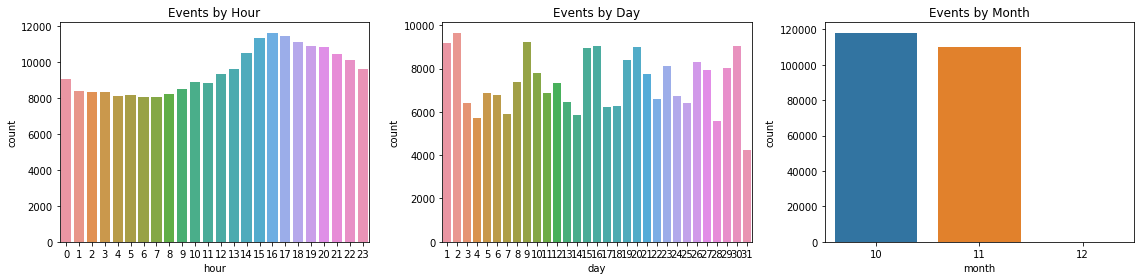

In [28]:
plt.figure(figsize=(16,4))

plt.subplot(131)
sns.countplot(x='hour',data=df_pd)
plt.title('Events by Hour')

plt.subplot(132)
sns.countplot(x='day',data=df_pd)
plt.title('Events by Day')

plt.subplot(133)
sns.countplot(x='month',data=df_pd)
plt.title('Events by Month')

plt.tight_layout()

Looks like we only have data from 2018 from the smaller dataset.

### Looking at User Behavior

#### Making a days with consecutive listens feature
It may be useful to keep a running tally of consecutive days a user listens to a song.

In [29]:
# Creating a column containing 1 if the event was a "NextSong" page visit or 0 otherwise
listen_flag = udf(lambda x: 1 if x=='NextSong' else 0, IntegerType())
df = df.withColumn('listen_flag',listen_flag('page'))
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', state='CA', hour=0, day=1, month=10, year=2018, date=datetime.date(2018, 10, 1), listen_flag=1)]

In [30]:
# Creating a second table where I will create this feature, then join it back to the main table later
df_listen_day = df.select(['userId','date','listen_flag']) \
                .groupBy(['userId','date']) \
                .agg(Fmax('listen_flag')).alias('listen_flag').sort(['userId','date'])
df_listen_day.show(10)

+------+----------+----------------+
|userId|      date|max(listen_flag)|
+------+----------+----------------+
|    10|2018-10-08|               1|
|    10|2018-10-18|               1|
|    10|2018-10-19|               1|
|    10|2018-10-29|               1|
|    10|2018-11-03|               1|
|    10|2018-11-15|               1|
|    10|2018-11-16|               1|
|    10|2018-11-19|               1|
|   100|2018-10-02|               1|
|   100|2018-10-03|               1|
+------+----------+----------------+
only showing top 10 rows



In [31]:
# Defining a window partitioned by User and ordered by date
window = Window \
        .partitionBy('userId') \
        .orderBy(col('date'))

# Using the above defined window and a lag function to create a previous day column
df_listen_day = df_listen_day \
                    .withColumn('prev_day',lag(col('date')) \
                    .over(window))
df_listen_day.show()

+------+----------+----------------+----------+
|userId|      date|max(listen_flag)|  prev_day|
+------+----------+----------------+----------+
|100010|2018-10-08|               1|      null|
|100010|2018-10-15|               1|2018-10-08|
|100010|2018-10-16|               1|2018-10-15|
|100010|2018-10-20|               1|2018-10-16|
|100010|2018-11-05|               1|2018-10-20|
|100010|2018-11-09|               1|2018-11-05|
|100010|2018-11-21|               1|2018-11-09|
|200002|2018-10-01|               1|      null|
|200002|2018-10-02|               1|2018-10-01|
|200002|2018-10-16|               1|2018-10-02|
|200002|2018-10-18|               1|2018-10-16|
|200002|2018-10-22|               1|2018-10-18|
|200002|2018-10-23|               1|2018-10-22|
|200002|2018-11-15|               1|2018-10-23|
|   125|2018-10-12|               1|      null|
|   124|2018-10-01|               1|      null|
|   124|2018-10-02|               1|2018-10-01|
|   124|2018-10-03|               1|2018

In [33]:
# Creating a udf to compare one date to another
def compare_date_cols(x,y):
    '''
    Compares x to y. Returns 1 if different
    '''
    if x != y:
        return 0
    else:
        return 1
date_group = udf(compare_date_cols, IntegerType())

# Creating another window partitioned by userId and ordered by date
windowval = (Window.partitionBy('userId').orderBy('date')
             .rangeBetween(Window.unboundedPreceding, 0))

df_listen_day = df_listen_day \
                        .withColumn( \
                            'date_group',
                             date_group(col('date'), date_add(col('prev_day'),1)) \
                                    # The above line checks if current day and previous day +1 day are equivalent
                                        # If They are equivalent (i.e. consecutive days), return 1
                            ) \
                        .withColumn( \
                             'days_consec_listen',
                             Fsum('date_group').over(windowval)) \
                        .select(['userId','date','days_consec_listen'])
                                    # The above lines calculate a running total summing consecutive listens

In [34]:
# Joining this intermediary table back into the original DataFrame
df = df.join(other=df_listen_day,on=['userId','date'],how='left')
shape_ps_df(df)

DF Shape: (278154,26)


In [35]:
df.where(col('page')=='NextSong') \
    .select(['userId','date','days_consec_listen']) \
    .sort(['userId','date']) \
    .dropDuplicates(['userId','date']) \
    .show()

+------+----------+------------------+
|userId|      date|days_consec_listen|
+------+----------+------------------+
|    10|2018-10-08|                 0|
|    10|2018-10-18|                 0|
|    10|2018-10-19|                 1|
|    10|2018-10-29|                 1|
|    10|2018-11-03|                 1|
|    10|2018-11-15|                 1|
|    10|2018-11-16|                 2|
|    10|2018-11-19|                 2|
|   100|2018-10-02|                 0|
|   100|2018-10-03|                 1|
|   100|2018-10-04|                 2|
|   100|2018-10-07|                 2|
|   100|2018-10-09|                 2|
|   100|2018-10-10|                 3|
|   100|2018-10-17|                 3|
|   100|2018-10-19|                 3|
|   100|2018-10-23|                 3|
|   100|2018-10-24|                 4|
|   100|2018-10-25|                 5|
|   100|2018-10-26|                 6|
+------+----------+------------------+
only showing top 20 rows



#### Making a days since last listen feature
It my also be useful to use this to measure inactivity.

In [36]:
# Isolating a few columns and taking the max aggregation to effectively remove duplicates
df_listen_day = df.select(['userId','date','listen_flag']) \
                .groupBy(['userId','date']) \
                .agg(Fmax('listen_flag')).alias('listen_flag').sort(['userId','date'])

In [37]:
df_listen_day.show()

+------+----------+----------------+
|userId|      date|max(listen_flag)|
+------+----------+----------------+
|    10|2018-10-08|               1|
|    10|2018-10-18|               1|
|    10|2018-10-19|               1|
|    10|2018-10-29|               1|
|    10|2018-11-03|               1|
|    10|2018-11-15|               1|
|    10|2018-11-16|               1|
|    10|2018-11-19|               1|
|   100|2018-10-02|               1|
|   100|2018-10-03|               1|
|   100|2018-10-04|               1|
|   100|2018-10-07|               1|
|   100|2018-10-09|               1|
|   100|2018-10-10|               1|
|   100|2018-10-17|               1|
|   100|2018-10-19|               1|
|   100|2018-10-23|               1|
|   100|2018-10-24|               1|
|   100|2018-10-25|               1|
|   100|2018-10-26|               1|
+------+----------+----------------+
only showing top 20 rows



In [38]:
# Re-stating the window
windowval = Window.partitionBy('userId').orderBy('date')

# Calculate difference (via datediff) between current date and previous date (taken with lag), and filling na's with 0
df_last_listen = df_listen_day.withColumn('days_since_last_listen',
                                            datediff(col('date'),lag(col('date')).over(windowval))) \
                            .fillna(0,subset=['days_since_last_listen']) \
                            .select(['userId','date','days_since_last_listen'])

In [39]:
# Joining back results
df = df.join(df_last_listen,on=['userId','date'],how='left')

In [40]:
df.take(1)

[Row(userId='110', date=datetime.date(2018, 11, 5), artist=None, auth='Logged In', firstName='William', gender='M', itemInSession=0, lastName='Thompson', length=None, level='free', location='Chicago-Naperville-Elgin, IL-IN-WI', method='GET', page='Home', registration=1537665002000, sessionId=1512, song=None, status=200, ts=1541379932000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', state='WI', hour=1, day=5, month=11, year=2018, listen_flag=0, days_consec_listen=0, days_since_last_listen=4)]

#### Running Listens By Month

Listens by month can also be a useful indicator of consistent user activity.

In [41]:
# Defining Window 
windowval = Window.partitionBy('userId').orderBy(date_trunc('month',col('date')))

# Creating separate intermediary DF. Using row_number() on each listen within each month to count monthly listens
df_running_listens = df \
                    .where(col('listen_flag')==1) \
                    .withColumn('running_listens_mon',row_number().over(windowval)) \
                    .select(['userId','ts','running_listens_mon','date'])

In [42]:
# Joining back into main DF
df = df.join(df_running_listens.select(['userId','ts','running_listens_mon']),
                                       on=['userId','ts'],how='left')

In [43]:
df.select(['userId','date','page','running_listens_mon']).sort(['userId','ts']).show()

+------+----------+----------+-------------------+
|userId|      date|      page|running_listens_mon|
+------+----------+----------+-------------------+
|    10|2018-10-08|  NextSong|                 22|
|    10|2018-10-08|  NextSong|                 23|
|    10|2018-10-08|  NextSong|                 24|
|    10|2018-10-08|  NextSong|                 25|
|    10|2018-10-08|  NextSong|                 26|
|    10|2018-10-08|  NextSong|                 27|
|    10|2018-10-08|  NextSong|                 28|
|    10|2018-10-08| Thumbs Up|               null|
|    10|2018-10-08|  NextSong|                 29|
|    10|2018-10-08|  NextSong|                 30|
|    10|2018-10-08|  NextSong|                 31|
|    10|2018-10-08|Add Friend|               null|
|    10|2018-10-08|Add Friend|               null|
|    10|2018-10-08|  NextSong|                 32|
|    10|2018-10-08|  NextSong|                 33|
|    10|2018-10-08| Thumbs Up|               null|
|    10|2018-10-08|  NextSong| 

##### Dealing with Missing Values in running monthly listens

This method creates a lot of null values. Let's see how many nulls we have...

In [44]:
df.where(col('running_listens_mon').isNull()).count()

49400

In [45]:
# Sorting by userId and timestamp
df = df.sort(['userId','ts'])

In [46]:
# Creating a window partitioned by userId and ordered by timestamp
windowval = Window.partitionBy(col('userId')).orderBy(col('ts'))

# Creating a lag of the new running listens column
running_listens_lag = lag(df['running_listens_mon']).over(windowval)

In [47]:
# When a null value is found, fill it with the previous value. 
    # This effectively frontfills null values with valid values that immediately precede it
df = df.withColumn('running_listens_mon_fill', 
              when(col('running_listens_mon').isNull(),running_listens_lag) \
                .otherwise(col('running_listens_mon')))

In [49]:
# Recounting nulls
df.where(col('running_listens_mon_fill').isNull()).count()

10389

Still have null values that have to be filled. Re-running the lag as a loop.

In [50]:
n_null = df.where(col('running_listens_mon_fill').isNull()).count()
n_null

10389

In [51]:
i = 0
while n_null > 0:
    # Re-creating a lag column based on the filled values
    running_listens_lag = lag(df['running_listens_mon_fill']).over(windowval)
    
    # Replacing 'running_listens_mon_fill' with new filled values
    df = df.withColumn('running_listens_mon_fill', 
                  when(col('running_listens_mon_fill').isNull(),running_listens_lag) \
                    .otherwise(col('running_listens_mon_fill')))

    n_null = df.where(col('running_listens_mon_fill').isNull()).count()
    i += 1
    print(f'Loop {i}\nNull values left: {n_null}')
    
    if i > 5:
        print('Breaking loop to save computation time. Filling remaining null values with 0.')
        df = df.fillna(0,subset=['running_listens_mon_fill'])

print(f'Done.\nNumber of null values remaining: {n_null}')

Loop 1
Null values left: 2979
Loop 2
Null values left: 1023
Loop 3
Null values left: 447
Loop 4
Null values left: 253
Loop 5
Null values left: 183
Breaking loop to save computation time. Filling remaining null values with 0.
Loop 6
Null values left: 0
Breaking loop to save computation time. Filling remaining null values with 0.
Done.
Number of null values remaining: 0


#### Flagging Based on Other Page Values

In [53]:
# Creating udf's to flag whenever a user visits each particular page
thU_flag = udf(lambda x: 1 if x=='Thumbs Up' else 0, IntegerType())
thD_flag = udf(lambda x: 1 if x=='Thumbs Down' else 0, IntegerType())
err_flag = udf(lambda x: 1 if x=='Error' else 0, IntegerType())
addP_flag = udf(lambda x: 1 if x=='Add to Playlist' else 0, IntegerType())
addF_flag = udf(lambda x: 1 if x=='Add Friend' else 0, IntegerType())

In [54]:
# Creating the flag columns
df = df.withColumn('thU_flag',thU_flag('page')) \
        .withColumn('thD_flag',thD_flag('page')) \
        .withColumn('err_flag',err_flag('page')) \
        .withColumn('addP_flag',addP_flag('page')) \
        .withColumn('addF_flag',addF_flag('page'))    

### Defining Churn

I will consider a page visit to `Cancellation Confirmation` or  `Downgrade` churn, which will be denoted by 1 in a `Churn` column.

In [56]:
def label_churn(x):
    '''
    INPUT
    x: Page
    
    OUTPUT
    Returns 1 if an instance of Churn, else returns 0
    '''
    if x=='Cancellation Confirmation':
        return 1
    elif x=='Downgrade':
        return 1
    else:
        return 0

# Creating udf
udf_label_churn = udf(label_churn, IntegerType())
# Creating column
df = df.withColumn('Churn',udf_label_churn(col('page')))

In [57]:
# Looking at average of the running listens per month by churn
df.groupBy('Churn').agg(Favg(col('running_listens_mon'))).show()

+-----+------------------------+
|Churn|avg(running_listens_mon)|
+-----+------------------------+
|    1|      1015.5918367346939|
|    0|      1106.3705909359219|
+-----+------------------------+



#### Calculating User Aggregations
Using the features I engineered above, I'll aggregate these for each user.
- For the metrics I calculated using Window functions (i.e. `running_listens_mon` or `days_consec_listen`), I'm taking the max
    - These represent *most listens in one month* and *most consecutive days spent listening to music* respectively
- For the flag metrics (i.e. `listen_flag` or `thU_flag`), I'm taking the total sum
    - These represent *total listens* and *total thumbs ups* respectively

In [59]:
df_listens_user = df.groupBy('userId') \
            .agg(Fmax(col('running_listens_mon_fill')).alias('most_listens_one_month'),
                 Fmax(col('days_since_last_listen')).alias('most_days_since_last_listen'),
                 Fmax(col('days_consec_listen')).alias('most_days_consec_listen'),
                 Fsum(col('listen_flag')).alias('total_listens'),
                 Fsum(col('thU_flag')).alias('total_thumbsU'),
                 Fsum(col('thD_flag')).alias('total_thumbsD'),
                 Fsum(col('err_flag')).alias('total_err'),
                 Fsum(col('addP_flag')).alias('total_add_pl'),
                 Fsum(col('addF_flag')).alias('total_add_fr')
                )
df_listens_user.show(5)

+------+----------------------+---------------------------+-----------------------+-------------+-------------+-------------+---------+------------+------------+
|userId|most_listens_one_month|most_days_since_last_listen|most_days_consec_listen|total_listens|total_thumbsU|total_thumbsD|total_err|total_add_pl|total_add_fr|
+------+----------------------+---------------------------+-----------------------+-------------+-------------+-------------+---------+------------+------------+
|100010|                   275|                         16|                      1|          275|           17|            5|        0|           7|           4|
|200002|                   387|                         23|                      2|          387|           21|            6|        0|           8|           4|
|   125|                     8|                          0|                      0|            8|            0|            0|        0|           0|           0|
|   124|                  40

#### Looking At User Session Data

Another potentially useful indicator is the extent to which users behave within each session. Below I'm first taking the total sum of each flag behavior (i.e. `listen_flag`) within each session.

In [60]:
df_sess = df.select(['userId','sessionId','listen_flag','thU_flag','thD_flag','err_flag','addP_flag','addF_flag']) \
            .groupBy(['userId','sessionId']) \
            .agg(Fsum(col('listen_flag')).alias('sess_listens'),
                 Fsum(col('thU_flag')).alias('sess_thU'),
                 Fsum(col('thD_flag')).alias('sess_thD'),
                 Fsum(col('err_flag')).alias('sess_err'),
                 Fsum(col('addP_flag')).alias('sess_addP'),
                 Fsum(col('addF_flag')).alias('sess_addF'))
df_sess.show()

+------+---------+------------+--------+--------+--------+---------+---------+
|userId|sessionId|sess_listens|sess_thU|sess_thD|sess_err|sess_addP|sess_addF|
+------+---------+------------+--------+--------+--------+---------+---------+
|   101|      635|         708|      35|       8|       0|       23|        6|
|   110|     1776|          18|       1|       0|       0|        0|        0|
|   120|      627|         236|      13|       2|       0|        3|        0|
|   122|      691|           6|       0|       0|       0|        0|        0|
|   140|      798|           3|       0|       0|       0|        0|        1|
|   153|     1794|          62|       5|       0|       1|        1|        1|
|    29|     1030|          13|       1|       0|       0|        1|        0|
|300011|       60|          27|       3|       0|       0|        1|        2|
|    35|     2270|          10|       0|       0|       0|        1|        0|
|    42|      433|          16|       0|       0|   

Now I'm taking the average over all each user's session to get a sense of how a user tends to behave in one session.

In [61]:
df_sess_agg = df_sess.groupBy('userId') \
                .agg(Favg(col('sess_listens')).alias('avg_sess_listens'),
                    Favg(col('sess_thU')).alias('avg_sess_thU'),
                    Favg(col('sess_thD')).alias('avg_sess_thD'),
                    Favg(col('sess_err')).alias('avg_sess_err'),
                    Favg(col('sess_addP')).alias('avg_sess_addP'),
                    Favg(col('sess_addF')).alias('avg_sess_addF'))
df_sess_agg.show()

+------+------------------+------------------+-------------------+-------------------+------------------+-------------------+
|userId|  avg_sess_listens|      avg_sess_thU|       avg_sess_thD|       avg_sess_err|     avg_sess_addP|      avg_sess_addF|
+------+------------------+------------------+-------------------+-------------------+------------------+-------------------+
|100010|39.285714285714285|2.4285714285714284| 0.7142857142857143|                0.0|               1.0| 0.5714285714285714|
|200002|              64.5|               3.5|                1.0|                0.0|1.3333333333333333| 0.6666666666666666|
|   125|               8.0|               0.0|                0.0|                0.0|               0.0|                0.0|
|    51|             211.1|              10.0|                2.1|                0.1|               5.2|                2.8|
|   124| 140.6551724137931| 5.896551724137931| 1.4137931034482758|0.20689655172413793| 4.068965517241379| 2.5517241379

I'm going to take the approach of creating a user-metric matrix (users by calculated metrics) and using this as the basis for training and predicting churn rather than using the original provided transactional streaming data.

I believe this is a good approach to this problem since this heavily simplifies the training and prediction process. If this were to be implemented in practice, a streaming pipeline would be required to feed into the user-metric matrix, and a model would predict churn from this matrix.

In [123]:
dfUserMatrix = df.groupBy('userId').agg(Fmax(col('gender')).alias('gender')
                                             ,Fmax(col('churn')).alias('churn'))

In [124]:
# Note the heavy class imbalance
dfUserMatrix.groupBy('churn').agg(count('*')).show()

+-----+--------+
|churn|count(1)|
+-----+--------+
|    1|     171|
|    0|      54|
+-----+--------+



In [125]:
dfUserMatrix = dfUserMatrix.join(df_listens_user,['userId']).join(df_sess_agg,['userId'])

In [126]:
shape_ps_df(dfUserMatrix)

DF Shape: (225,18)


## Prepping Data For Model

In [127]:
gender_indexer = StringIndexer(inputCol='gender',outputCol='gender_indexed')
fitted_gender_indexer = gender_indexer.fit(dfUserMatrix)
dfModel = fitted_gender_indexer.transform(dfUserMatrix)

In [128]:
dfModel.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- most_listens_one_month: integer (nullable = true)
 |-- most_days_since_last_listen: integer (nullable = true)
 |-- most_days_consec_listen: long (nullable = true)
 |-- total_listens: long (nullable = true)
 |-- total_thumbsU: long (nullable = true)
 |-- total_thumbsD: long (nullable = true)
 |-- total_err: long (nullable = true)
 |-- total_add_pl: long (nullable = true)
 |-- total_add_fr: long (nullable = true)
 |-- avg_sess_listens: double (nullable = true)
 |-- avg_sess_thU: double (nullable = true)
 |-- avg_sess_thD: double (nullable = true)
 |-- avg_sess_err: double (nullable = true)
 |-- avg_sess_addP: double (nullable = true)
 |-- avg_sess_addF: double (nullable = true)
 |-- gender_indexed: double (nullable = false)



In [129]:
features = [col for col in dfModel.columns if col not in ('userId','gender','churn')]

In [130]:
assembler = VectorAssembler(inputCols=features,
                            outputCol='features')
dfModelVec = assembler.transform(dfModel)

In [131]:
dfModelVec = dfModelVec.select(col('features'),col('Churn').alias('label'))

## Modeling

In [132]:
# Scaling to mean 0 and unit std dev
scaler = StandardScaler(inputCol='features', outputCol='features_scaled', withMean=True, withStd=True)
scalerModel = scaler.fit(dfModelVec)

In [133]:
dfModelVecScaled = scalerModel.transform(dfModelVec)

In [134]:
dfMain = dfModelVecScaled.select(col('features_scaled').alias('features'),col('label'))

In [135]:
# Train/Test split
df_train, df_test = dfMain.randomSplit([0.8,0.2], seed=42)

In [136]:
def train_eval(model,df_train=df_train, df_test=df_test):
    '''
    INPUT
    model: ML Model to train
    df_train: DataFrame with data
    numFolds: Num folds for K-Fold Cross Validation
    seed: Random Seed
    
    OUTPUT
    None
    '''
    print(f'Training {model}...')
    # Instantiating Evaluators
    acc_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    
    # Training and predicting with model
    modelFitted = model.fit(df_train)
    results = modelFitted.transform(df_test)
    
    # Calculating metrics
    acc = acc_evaluator.evaluate(results)
    f1 = f1_evaluator.evaluate(results)
    
    print(f'{str(model):<35s}Accuracy: {acc:<4.2%} F-1 Score: {f1:<4.3f}') 

In [137]:
# Arbitrarily picked these three algorithms to try
lr = LogisticRegression(maxIter=30)
gbt = GBTClassifier()
rf = RandomForestClassifier()

Below are the results from an initial evaluation pass through each of the three selected algorithms. We'll proceed with tuning `GBTClassifier` since it resulted in the highest Accuracy and F-1 Score.

In [138]:
for model in [lr, gbt, rf]:
    train_eval(model)

Training LogisticRegression_98795b660a57...
LogisticRegression_98795b660a57    Accuracy: 76.47% F-1 Score: 0.775
Training GBTClassifier_7d4c69401dd0...
GBTClassifier_7d4c69401dd0         Accuracy: 79.41% F-1 Score: 0.799
Training RandomForestClassifier_1e2e472cacf8...
RandomForestClassifier_1e2e472cacf8Accuracy: 76.47% F-1 Score: 0.781


---

#### Tuning The Model

Because of the very few data points that we have, it would be beneficial to train our final model using K-Fold cross validation, which is automatically done with the `CrossValidator` along with a Grid Search using `ParamGridBuilder`.

In [142]:
# Going for a very small grid because of compute time
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[3,5]) \
    .addGrid(gbt.maxBins,[16,32]) \
    .build()

In [143]:
crossVal = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3,
                          seed=42,
                          parallelism=2)

In [144]:
cvModel = crossVal.fit(df_train)

In [145]:
# Now evaluating on the test set
predictions = cvModel.transform(df_test)

In [146]:
# Re-evaluating metrics using the resulting model
acc_eval = MulticlassClassificationEvaluator(metricName='accuracy')
f1_eval = MulticlassClassificationEvaluator(metricName='f1')

In [149]:
# Calculating metrics
acc = acc_eval.evaluate(predictions)
f1 = f1_eval.evaluate(predictions)
print(f'Accuracy: {acc:<4.2%} F-1 Score: {f1:<4.3f}') 

Accuracy: 82.35% F-1 Score: 0.831


In [168]:
# Hyperparameters of the best performing model
for key, value in cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)].items():
    print(f'{key}: {value}')

GBTClassifier_7d4c69401dd0__maxDepth: 3
GBTClassifier_7d4c69401dd0__maxBins: 16


In [194]:
# Saves trained model into a filepath determined by timestamp and string representation of the model object and scores
model_file_path = str(datetime.datetime.now().timestamp())+'_'+str(cvModel)+'_'+'Acc_'+str(round(acc,3))+'_'+'F1_'+str(round(f1,3))

In [195]:
cvModel.save(model_file_path)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import count, col, udf, desc, max as Fmax, lag, struct, date_add, sum as Fsum, \
                        datediff, date_trunc, row_number, when, coalesce, avg as Favg
from pyspark.sql.types import IntegerType, DateType

# from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime

In [ ]:
def main():
    spark = SparkSession \
        .builder \
        .appName("Sparkify") \
        .getOrCreate()
    
    df = 'link to s3 bucket'
    

In [ ]:
if __name__ == '__main__':
    main()